# *Лабораторная работа №4*

## Предсказание эмоциональной окраски отзыва на основе анализа естественного языка (Теоретическая часть)

Рассмотрим набор данных IMDB, содержащий 50 000 обзоров фильмов с точки зрения обработки естественного языка.

Этот набор данных для бинарной классификации эмоциональной окраски. Набор состоит из 25 000 высокорелевантных обзоров фильмов для обучения и 25 000 для тестирования.

Подключим большую часть необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action="ignore")
import tensorflow as tf

Загрузим набор данных.

In [2]:
%%capture
!wget https://www.dropbox.com/s/7sokxhbwg2kz33k/IMDB%20Dataset.csv

Считаем загруженный набор данных в dataframe для дальнейшей обработки.

In [3]:
df = pd.read_csv("IMDB Dataset.csv")
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Проверим основную информацию о представленном наборе данных.

In [4]:
df.shape

(50000, 2)

In [5]:
df.isna().sum()

,0
review,0
sentiment,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Переведем текстовую оценку эмоциональной окраски отзыва в целочисленный вид.

In [7]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
df.sentiment.unique()

array([1, 0])

<Axes: xlabel='sentiment', ylabel='count'>

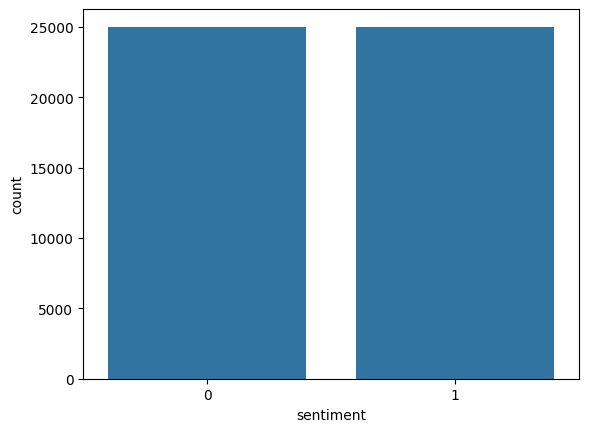

In [23]:
sns.countplot(df, x = "sentiment")

In [10]:
df["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


Необходимо очистить наш набор данных от зашумляющей информации и привести весь текст к нижнему регистру.

In [11]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"http", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"@", "at")
    df[content_field] = df[content_field].str.lower()
    return df

In [12]:
standardize_text(df,"review")

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,"bad plot, bad dialogue, bad acting, idiotic di...",0
49997,i am a catholic taught in parochial elementary...,0
49998,i'm going to have to disagree with the previou...,0


Подключим несколько библиотек для обработки естественного языка.

In [13]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Операции лемматизации, очистки от стоп-слов и иже с ними занимают очень много времени, так что после запуска следующего кода у Вас будет минимум минут 20 свободного времени.

In [14]:
lemmatizer=WordNetLemmatizer()
corpus = []
for i in range(0,len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    review = review.split()
    review=[word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review=' '.join(review)
    corpus.append(review)

Проведем векторизацию нашего текста с помощью TF-IDF.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3))
X = tfidf.fit_transform(corpus)
y = df["sentiment"]

Разобьем набор данных на тренировочную и тестовую выборки.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Воспользуемся моделью опорных векторов для проведения классификации.

In [17]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC()

In [18]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array([1, 0, 1, 1, 1])

Выведем результаты работы нашего классификатора в виде матрицы неточностей и метрики точности.

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4955
           1       0.91      0.89      0.90      5045

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy Score of SVC: 90.02 %


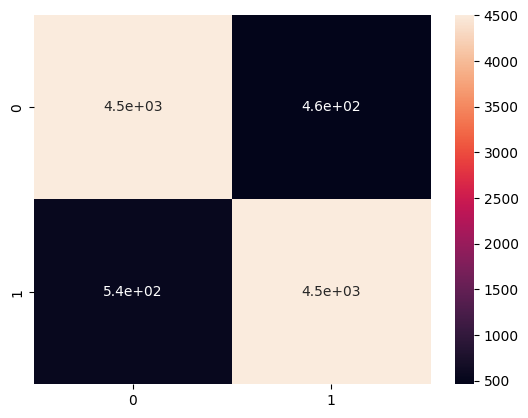

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True)
print(report)
print("Accuracy Score of SVC:", acc*100,"%")

## Предсказание эмоциональной окраски отзыва на основе анализа естественного языка (Практическая часть)

Вашим заданием в данной лабораторной будет построение модели анализа естественного языка для определения эмоциональной окраски отзыва. Вам для обработки предлагается коллекция рецензий пользователей на фильмы с сайта kinopoisk.ru

https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews

Ниже приведен блок кода для загрузки тренировочной (разделение ее на обучающую и тестовую части остается на усмотрение исполнителя) и валидационной выборки. Валидационная часть не участвует в обучении, только в получении итоговой оценки.

Методика оценки - *accuracy_score*

In [ ]:
%%capture
!wget -O kp_train.csv https://www.dropbox.com/scl/fi/mzvuxvjheh6sjzzu8nio9/kp_train.csv?rlkey=dm2k7kbgwhs2bebj3lejzg2ag&dl=0
!wget -O kp_valid.csv https://www.dropbox.com/scl/fi/4g75r45ntfxsv2evbpr9u/kp_valid.csv?rlkey=631t34qfnq38rn92akc5h10pi&dl=0

In [ ]:
import pandas as pd

df = pd.read_csv("kp_train.csv", sep='|')
df_val = pd.read_csv("kp_valid.csv", sep='|')

In [ ]:
df

,review,sentiment
0,Сегодня в очередной раз пересмотрел один из мо...,pos
1,На фильм попал случайно. Шел просто скоротать ...,pos
2,Накануне Дня космонавтики на российские экраны...,neu
3,Моя любимая комедия. На порядок выше голливудс...,pos
4,Астронавт Чак Бейкер прилетает на неизведанную...,pos
...,...,...
56995,"Город Ном, центр Клондайка, куда на Аляску вре...",pos
56996,Как же я давно ищу хороший мясной фильм которы...,neu
56997,Отличный дебют Александра Аджа. Видно откуда о...,pos
56998,"Фильм является пропагандой нездоровых, пагубны...",neu
